# Convolutional Neural Network for distingush quark initiated jets from gluon initiated jets


### Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('drive')

Mounted at drive


## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [ ]:
# apply transformations on training set to avoid overfitting
# simple geometrical transormations (zoom, rotations, shifts) --> Images Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)

training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/data/training_set',
    target_size = (33, 33),
    batch_size = 128,
    class_mode = 'binary' #choose categorical for more than two output
)

Found 18257 images belonging to 2 classes.


### Preprocessing the Test set

In [ ]:
# here we don't touch the geometry of images, but we reascale the features
test_datagen = ImageDataGenerator(rescale = 1./255.,
)
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/data/validation_set',
    target_size = (33, 33),
    batch_size = 128,
    class_mode = 'binary'
)

Found 2301 images belonging to 2 classes.


### Visualize a single image (optional)

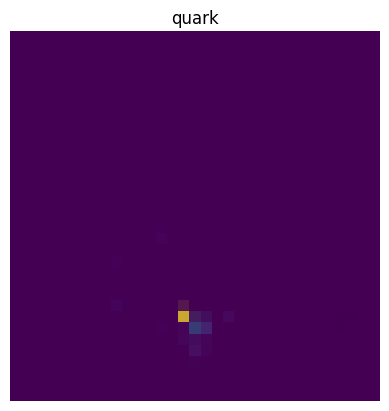

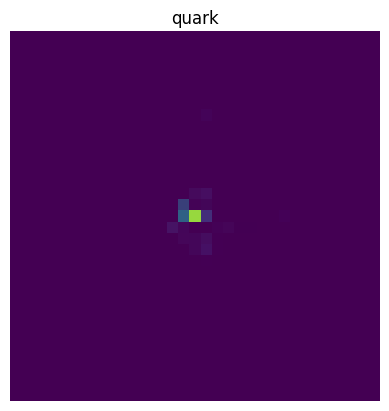

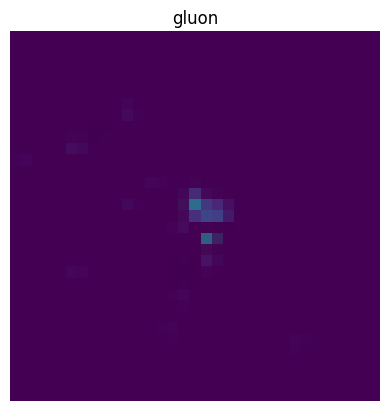

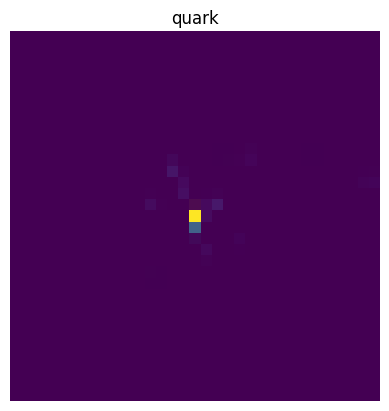

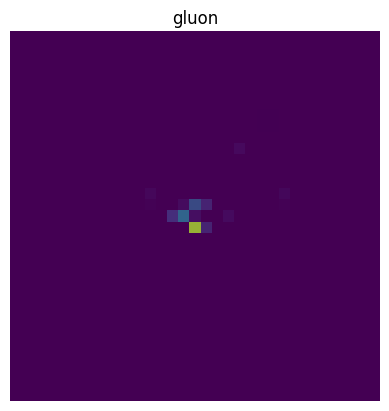

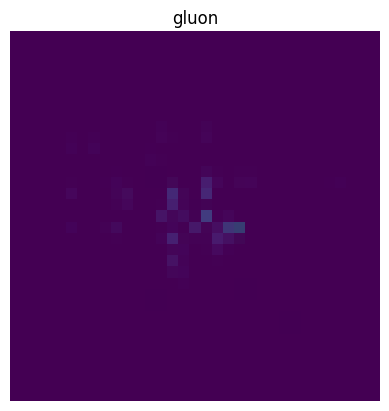

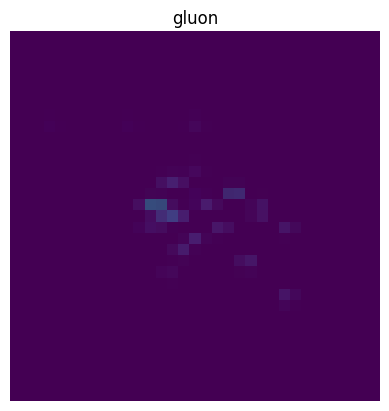

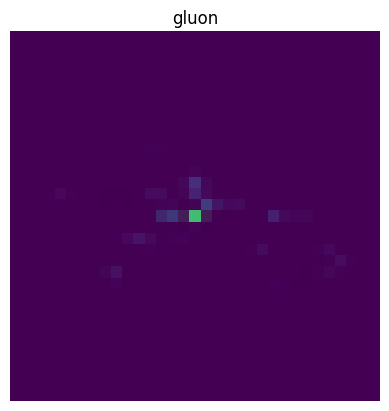

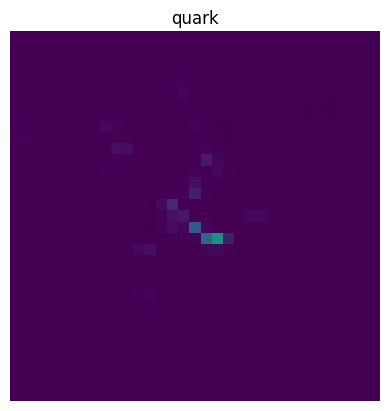

In [ ]:
#load a batch of images with theyr labels
images, labels = training_set[0]

#print a bounch of images with theyr labels
for i in range(1, 10):
  image = images[i]*255
  label = labels[i]
  if label == 0.:
    particle = 'gluon'
  else: particle = 'quark'
  # Display original image
  plt.imshow(image.astype(np.uint8))
  plt.axis('off')
  plt.title('{}'.format(particle))
  plt.show()

### Initialising the CNN

In [ ]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [ ]:
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, kernel_size = 3, activation = 'relu',
    padding = 'same', input_shape = [33, 33, 3]
))

### Step 2 - Pooling

In [ ]:
# apply max pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

### Adding a second and third convolutional layer

In [ ]:
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, kernel_size = 3,
    activation = 'relu', padding = 'same'
))

cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

In [ ]:
cnn.add(tf.keras.layers.Conv2D(
    filters = 32, kernel_size = 3, activation = 'relu'
))

cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 1))

### Step 3 - Flattening

In [ ]:
# flat everything in a 1D array or vector
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [ ]:
# we choose a large numbers of neurons
cnn.add(tf.keras.layers.Dense(
    units = 128, activation = 'relu'
))

### Step 5 - Output Layer

In [ ]:
cnn.add(tf.keras.layers.Dense(
    units = 1, activation = 'sigmoid'
))

## Part 3 - Training the CNN

### Compiling the CNN

In [ ]:
cnn.compile(optimizer = 'adam' , loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

### Training the CNN on the Training set and evaluating it on the Test set

In [ ]:
history = cnn.fit(
    x = training_set,
    validation_data = test_set,
    epochs = 50,
    callbacks = [early_stopping]
)

Epoch 1/50
143/143 [==============================] - 3411s 22s/step - loss: 0.5975 - binary_accuracy: 0.6899 - val_loss: 0.5715 - val_binary_accuracy: 0.7132
Epoch 2/50
143/143 [==============================] - 689s 5s/step - loss: 0.5773 - binary_accuracy: 0.7104 - val_loss: 0.5704 - val_binary_accuracy: 0.7223
Epoch 3/50
143/143 [==============================] - 715s 5s/step - loss: 0.5710 - binary_accuracy: 0.7138 - val_loss: 0.5526 - val_binary_accuracy: 0.7240
Epoch 4/50
143/143 [==============================] - 685s 5s/step - loss: 0.5675 - binary_accuracy: 0.7147 - val_loss: 0.5497 - val_binary_accuracy: 0.7345
Epoch 5/50
143/143 [==============================] - 686s 5s/step - loss: 0.5594 - binary_accuracy: 0.7225 - val_loss: 0.5418 - val_binary_accuracy: 0.7371
Epoch 6/50
143/143 [==============================] - 676s 5s/step - loss: 0.5559 - binary_accuracy: 0.7248 - val_loss: 0.5507 - val_binary_accuracy: 0.7306
Epoch 7/50
143/143 [==============================] - 66

UnknownError: ignored

Fit the loss and the accuracy


In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## Save the model for futue uses

In [ ]:
cnn.save('/content/drive/MyDrive/colab_notebooks/trained_models/cnn_10k/')

## Print on screen the ROC and AUC ROC


In [ ]:
from sklearn.metrics import roc_curve, auc

#Make prediction on a set of data
predicted_prob = cnn.predict(test_set)

# Label the predicted probability
predicted_labels = (predicted_prob >= 0.5).astype(int)
true_labels = test_set.labels

positive_pred_labels = predicted_labels[:, 0]
#print(predicted_labels, true_labels)

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Binary Classification')
plt.legend(loc="lower right")
plt.show()

## Part 4 - Making a single prediction

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

test_image = image.load_img( '/content/drive/MyDrive/data/single_prediction/quark_jet_51.jpg', target_size = [33, 33])

#convert test image to an array
test_image = image.img_to_array(test_image)

# now, the image has to be into a batch, we add an extra dimension corresponding to the batch
test_image = np.expand_dims(test_image, axis = 0)

result = cnn.predict(test_image)

# We obtain a 0/1 result, we have to encode it:
training_set.class_indices

if result[0][0] == 1:
  prediction = 'gluon'
else :  prediction = 'quark'

print(prediction)
